In [3]:
# 1D chain of spinless atoms with infinite Coulomb repulsion

In [18]:
import numpy as np
import numpy.linalg as LA
from tqdm import tqdm

import time
import matplotlib.pyplot as plt

In [19]:
# parameters

Ns = 100   # number of sites
Np = 4   # number of particles, filling = Np/Ns

MCsteps = int(1.e4)

burn = 1.e3     # how many steps to burn
sweep = 1.e3    # sample configs after what steps

In [20]:
def pbc(n):
    if n<0:
        return n+Ns
    elif n>=Ns:
        return n-Ns
    else:
        return n

In [21]:
# single particle states

all_sp_states = np.arange(-np.pi, np.pi, 2*np.pi/Ns)
energy = all_sp_states*all_sp_states
idx = energy.argsort()[:]
all_sp_states_energy_sorted = all_sp_states[idx]

In [22]:
# for our problem, we only need Np of the lowest states

sp_states = all_sp_states_energy_sorted[0:Np]

In [23]:
# particle positions

def psi(particle_positions,g):

    # slater determinant
    slater = np.zeros([Np,Np]).astype(complex)

    for i in range(Np):
        for j in range(Np):
            ki = sp_states[i]
            rj = particle_positions[j]
            slater[i,j] = np.exp(1j*ki*rj)

    # jastrow factor
    jastrow = 1.0
    for p1 in particle_positions:
        ngbr = [pbc(p1-1),pbc(p1+1)]
        if ngbr in particle_positions:  # neareast neighbors
            jastrow = jastrow*g

    return jastrow*LA.det(slater)

In [24]:
# now let's do a MC step

# start with random position

def GiveList(g):
    init_pos = np.random.choice(Ns, Np, replace=False)

    rij_list = []

    pos = init_pos

    for step in range(MCsteps):
        
        prob = np.abs(psi(pos,g))**2
        
        # select a particle at random
        pp_rand = np.random.randint(Np)
        # change its position
        new_pos = np.copy(pos)
        # give it a kick
        kick = np.random.choice(np.setdiff1d(np.arange(Ns),pos))
        # update the position
        new_pos[pp_rand] = kick
        # calculate the new probability
        prob_new = np.abs(psi(new_pos,g))**2

        # is it any better?
        ratio = prob_new/prob
        
        # make the move
        if (ratio > 1):
            pos = new_pos
            prob = prob_new
#            acpr += 1.0/MCsteps
        else:
            r = np.random.random()  # metropolis step
            if (r < ratio ):
                pos = new_pos
                prob = prob_new
#                acpr += 1.0/MCsteps     # acceptance ratio

        if (step > burn and step%sweep ==0):
            rij_list.append(pos)

    return rij_list    
#print('acceptance ratio', acpr)
    

In [26]:
# save all configs
gar = np.arange(0,1,0.01)
saveConfigs = []
for g in tqdm(gar):
    saveConfigs.append(GiveList(g))

100%|██████████| 100/100 [08:21<00:00,  5.01s/it]


In [ ]:
# observables
# given a list, how do you calculate total Energy?

def PE(mclist,U):
    Nmc = len(mclist)
    # each step has a set of positions
    pe = []
    for config in mclist:
        pin = 0.0
        for pos in config:
            if np.isin(pbc(pos-1),config):
                pin += U
            if np.isin(pbc(pos+1),config):
                pin += U
        pe.append(pin)
    
    return np.mean(pe)

def KE(mclist,U):
    Nmc = len(mclist)
    # each step has a set of positions
    ke = []
    for config in mclist:
        kin = 0.0
        for pos in config:
            
        pe.append(pin)
    
    return np.mean(pe)

In [13]:
Uar = np.arange(0,10,0.5)

plotData = []
for U in tqdm(Uar):
    pear = []
    for mclist in saveConfigs:
        pot_energy = PE(mclist,U)
        pear.append( pot_energy )

    plotData.append(pear)    

100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


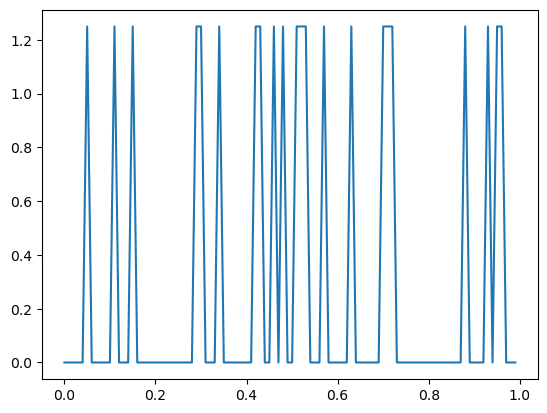

In [17]:
plt.plot(gar,plotData[10] )
plt.show()